In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm 
import scanpy as sc
from matplotlib.pyplot import rc_context
from matplotlib.gridspec import GridSpec

/home/dsikdar/.conda/envs/r_env_431/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dsikdar/.conda/envs/r_env_431/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dsikdar/.conda/envs/r_env_431/lib/python3.10/site-packages/uma

# 7 samples RNA

In [2]:
#data = pg.read_input('/gpfs/gibbs/pi/girgenti/JZhang/CL/C2C/AD_Paper/Data/AMP-AD_ROSMAP_annotated.h5ad')
data = pg.read_input('/extra/zhanglab0/CommonData/AMP-AD/AMP-AD_restricted/AMP-AD_ROSMAP_annotated.h5ad')

2024-02-27 10:57:34,281 - pegasusio.readwrite - INFO - h5ad file '/extra/zhanglab0/CommonData/AMP-AD/AMP-AD_restricted/AMP-AD_ROSMAP_annotated.h5ad' is loaded.
2024-02-27 10:57:34,284 - pegasusio.readwrite - INFO - Function 'read_input' finished in 28.31s.


In [3]:
data.obs['subclass'] = data.obs['subclass'].replace(['L5 ET', 'L5 IT'], 'L5')

In [4]:
data.obs['canon'] = None

In [5]:
data.obs['subclass'].cat.categories

Index(['Astro', 'Chandelier', 'Endo', 'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Lamp5 Lhx6',
       'Micro/PVM', 'OPC', 'Oligo', 'Pax6', 'Pvalb', 'Sncg', 'Sst',
       'Sst Chodl', 'VLMC', 'Vip'],
      dtype='object')

In [6]:
data.obs

,n_genes,n_counts,Channel,anno,subclass,azimuth,sampleID,individualID,canon
barcodekey,,,,,,,,,
D17-8753-TGCGCAGCATCGGGTC,10905,66946,D17-8753-,L5 ET,L2/3 IT,L2/3 IT,D17-8753,ROS13,None
D17-8753-CTCGAAACATCGACGC,10375,59114,D17-8753-,L5 ET,L6 IT,L6 IT,D17-8753,ROS13,None
D17-8753-TGCGCAGGTATCGCAT,10518,58903,D17-8753-,L5 ET,L6 IT,L6 IT,D17-8753,ROS13,None
D17-8753-GTTACAGCACATTAGC,10268,49493,D17-8753-,L5 ET,L2/3 IT,L2/3 IT,D17-8753,ROS13,None
D17-8753-TCCCGATCAATGTTGC,9969,48719,D17-8753-,L5 IT-5,L6 IT,L6 IT,D17-8753,ROS13,None
...,...,...,...,...,...,...,...,...,...
D17-8800-GGACATTCATTCTCAT,566,760,D17-8800-,Astro-2,Astro,Astro,D17-8800,ROS40,None
D17-8800-CGATGTAAGGGTTTCT,542,753,D17-8800-,Micro/PVM,Micro/PVM,Micro/PVM,D17-8800,ROS40,None
D17-8800-CTGATCCCAATGGACG,532,742,D17-8800-,Oligo-4,Oligo,Oligo,D17-8800,ROS40,None


In [8]:
remove = ['Sst Chodl']
barcode_list = []
for ii,name in enumerate(data.obs_names):
    if data.obs.subclass[ii] in remove:
        barcode_list.append(False)
    else:
        barcode_list.append(True)
data_subset = data[barcode_list].copy()

In [9]:
data = MultimodalData(data_subset)

In [7]:
data.obs['subclass'].cat.remove_categories("Sst Chodl", inplace=True)

/home/dsikdar/.conda/envs/r_env_431/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [8]:
data.obs['subclass'].cat.categories

Index(['Astro', 'Chandelier', 'Endo', 'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Lamp5 Lhx6',
       'Micro/PVM', 'OPC', 'Oligo', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'VLMC',
       'Vip'],
      dtype='object')

In [9]:
ann = sc.AnnData(data.X)
ann.var_names = data.var_names
ann.obs_names = data.obs_names

In [10]:
ann.obs['Subclass'] = data.obs['subclass']

In [11]:
ann.obsm['umap'] = data.obsm['X_umap']

In [12]:
celltype_name = ["Astro","Endo","Micro/PVM","Oligo","OPC","VLMC",
                  "Chandelier","Lamp5","Lamp5 Lhx6","Pax6","Pvalb","Sncg","Sst","Vip",
                  "L2/3 IT","L4 IT","L5","L5/6 NP","L6 CT","L6 IT","L6 IT Car3","L6b"]

In [13]:
len(celltype_name)

22

In [14]:
colors=['#FF7A9E', '#DBA300', '#59C200', '#00CEB7', '#00B7FF', '#F07DFF',
'#FF0000', '#FF1700', '#FF2F00', '#FF4600', '#FF5E00', '#FF7500', '#FF8D00', '#FFA500',
'#0000FF', '#0024DA', '#0048B6', '#006D91', '#00916D', '#00B648', '#00DA24', '#00FF00']

In [15]:
colors_matched=['#FF7A9E', '#FF0000', '#DBA300', '#0000FF', '#0024DA', '#0048B6', '#006D91', 
                '#00916D', '#00B648', '#00DA24', '#00FF00', '#FF1700', '#FF2F00', 
                '#59C200', '#00B7FF', '#00CEB7', '#FF4600', '#FF5E00', '#FF7500', '#FF8D00', '#F07DFF', 
                '#FFA500']

In [16]:
len(colors_matched)

22

/home/dsikdar/.conda/envs/r_env_431/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


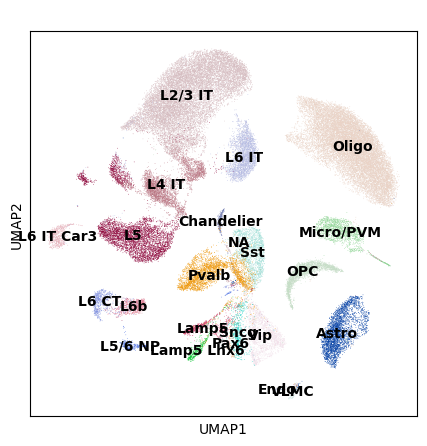

In [17]:
with rc_context({'figure.figsize': (5, 5)}):
    # sc.pl.umap(ann, color='Subclass', size=1, add_outline=True, legend_loc='right',palette=colors_matched, save='_7samples_rna.pdf',title=' ')
    sc.pl.umap(ann, color='Subclass', size=1, add_outline=False, legend_loc='on data',save='_7samples_rna-no_outline.pdf',title=' ')